In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, BatchNormalization
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import random
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

## Utility

In [2]:
class DDPGProcessor(WhiteningNormalizerProcessor):
    def process_action(self, actions):
        return np.random.choice([0,1], p=actions)

class CustomDDPGAgent(DDPGAgent):
    def select_action(self, state):
        eps = 0.1
        if self.training and np.random.uniform() < eps:
            return [0.5, 0.5]
        else:
            return super(CustomDDPGAgent, self).select_action(state)
        


## Different Configurations

In [3]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=20)
obs_shape = (20, 2)
env = env_creator()
nb_actions = env.action_space.n

def actorModel():
    model = Sequential()
    model.add(Conv2D(input_shape=(1,) + obs_shape, filters=32, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model
#actorModel().summary()

def criticModel():
    action_input = Input(shape=(2,), name='action_input')
    observation_input = Input(shape=(1,) + obs_shape, name='observation_input')
    x = Conv2D(filters=32, kernel_size=(4,2), padding='same', activation='relu')(observation_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(4,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    flattened_observation = Flatten()(x)
    
    #flattened_observation = Flatten()(observation_input)
    y = Concatenate()([action_input, flattened_observation])
    y = Dense(512)(y)
    y = Activation('relu')(y)
    y = Dense(256)(y)
    y = Activation('relu')(y)
    y = Dense(1)(y)
    output = Activation('linear')(y)
    critic = Model(inputs=[action_input, observation_input], outputs=output)
    #print("critic")
    #critic.summary()
    return critic, action_input
#criticModel()[0].summary()
def agent_creator():
    memory = SequentialMemory(limit=2048, window_length=1)
    processor = DDPGProcessor()
    
    critic, action_input = criticModel()
    agent = CustomDDPGAgent(nb_actions=2, actor=actorModel(), critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=None,processor=processor, gamma=.95, target_model_update=1e-3)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

In [4]:
from evaluator import Evaluator

#e = Evaluator(agent_creator, env_creator, name="ddpg")
#e.train(repeat=1)


In [5]:
#e.process_train_result()
#e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=20))

In [6]:
from data import EURUSD_HOUR
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'AskClose'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['AskOpen','AskHigh','AskLow','AskClose','AskChange']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data

def env_creator():
    return MyForexEnv(df=EURUSD_HOUR, window_size=30, frame_bound=(50, 80000))
env = env_creator()
obs_shape = (30, 5)
print("max possible profit: {}".format(env.max_possible_profit()))
def actorModel():
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + obs_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model
#actorModel().summary()

def criticModel():
    action_input = Input(shape=(2,), name='action_input')
    observation_input = Input(shape=(1,) + obs_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    
    #flattened_observation = Flatten()(observation_input)
    y = Concatenate()([action_input, flattened_observation])
    y = Dense(1024)(y)
    y = Activation('relu')(y)
    y = Dense(1024)(y)
    y = Activation('relu')(y)
    y = Dense(1024)(y)
    y = Activation('relu')(y)
    y = Dense(1)(y)
    output = Activation('linear')(y)
    critic = Model(inputs=[action_input, observation_input], outputs=output)
    #print("critic")
    #critic.summary()
    return critic, action_input
#criticModel()[0].summary()
def agent_creator():
    memory = SequentialMemory(limit=2048, window_length=1)
    processor = DDPGProcessor()
    
    critic, action_input = criticModel()
    agent = CustomDDPGAgent(nb_actions=2, actor=actorModel(), critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=None,processor=processor, gamma=.95, target_model_update=1e-3)
    agent.compile(Adam(lr=.0001, clipnorm=1.), metrics=['mae'])
    return agent

max possible profit: 2485856055592.9863


Instructions for updating:
Colocations handled automatically by placer.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
  144/15989 [..............................] - ETA: 21s - reward: -0.6944 - cumulative_reward: -163.9375WARNING:tensorflow:From /Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
15989/15989 [==============================] - 286s 18ms/step - reward: 0.0318 - cumulative_reward: 986.0613
train 1 completed. took 288.959 seconds, total_reward: 508.600000000049 total_profit: 0.26425044105785483
min reward: -899.0000000000009, max reward: 429.1, mean_reward: 0.006361555491626525


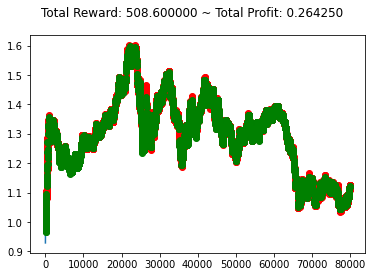

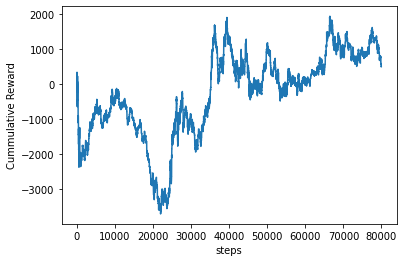

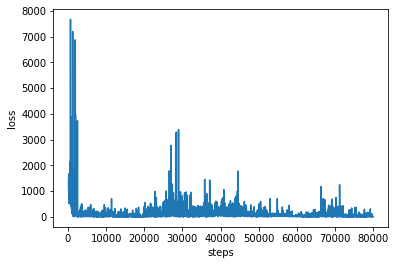

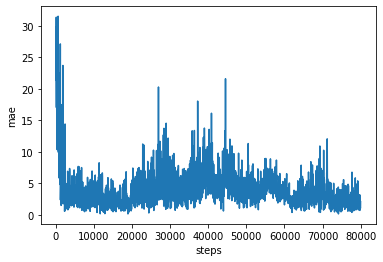

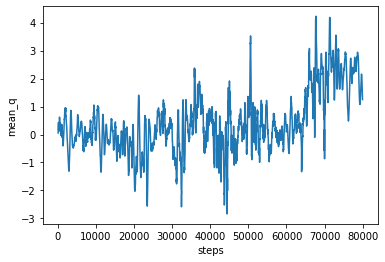

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 310s 19ms/step - reward: 0.5251 - cumulative_reward: 7148.7641
train 2 completed. took 605.930 seconds, total_reward: 8396.899999999969 total_profit: 0.5419118982498493
min reward: -512.0000000000014, max reward: 817.9999999999987, mean_reward: 0.10502820548099374


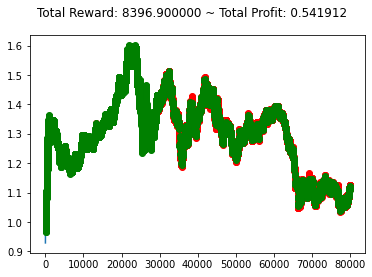

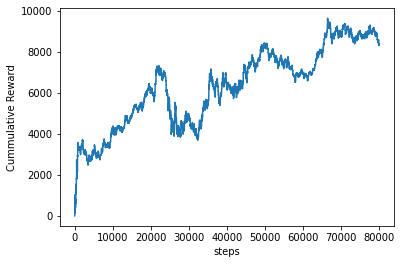

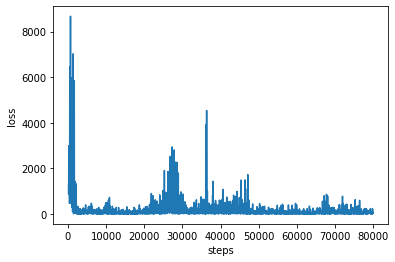

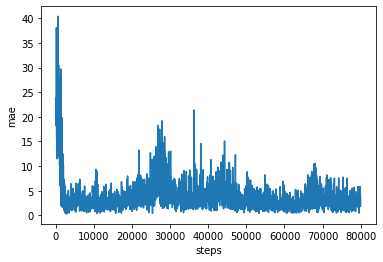

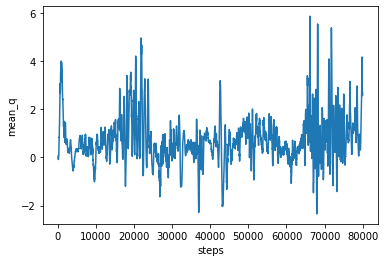

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 311s 19ms/step - reward: 4.5865 - cumulative_reward: 4768.0485
train 3 completed. took 924.519 seconds, total_reward: 6179.599999999883 total_profit: 0.4678937019980872
min reward: -634.7999999999998, max reward: 612.5000000000002, mean_reward: 0.07729427510037502


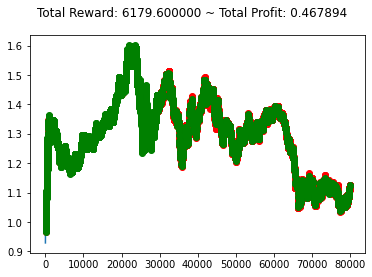

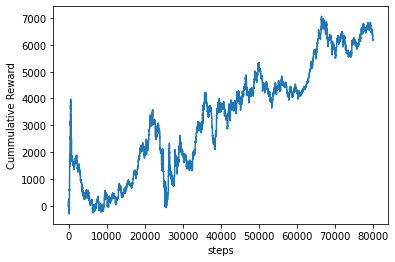

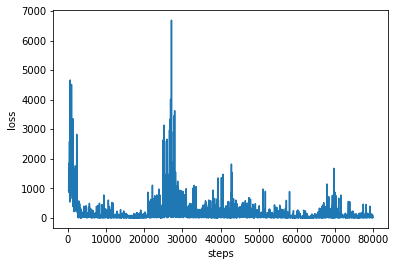

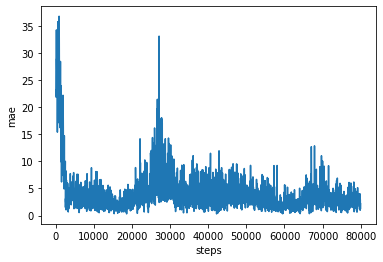

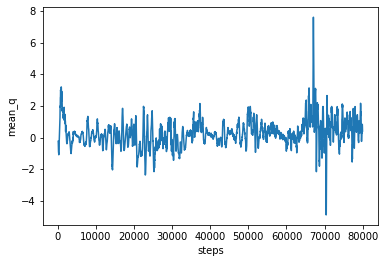

In [7]:
e = Evaluator(agent_creator, env_creator, name="ddpg-90k")
e.train(repeat=3)

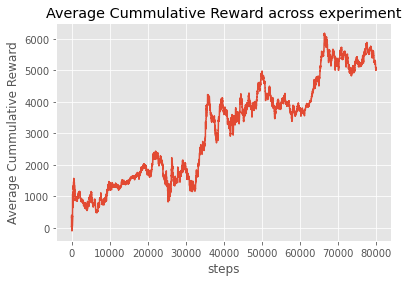

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
1999/1999 [==============================] - 14s 7ms/step - reward: 0.0000e+00 - cumulative_reward: 0.0000e+00
Episode 1: reward: 0.000, steps: 9999
test completed. total_reward: 0.0 total_profit: 0.9773363178511473
min reward: 0.0, max reward: 0.0, mean_reward: 0.0


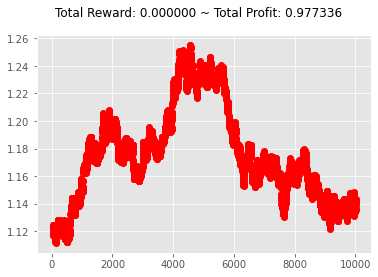

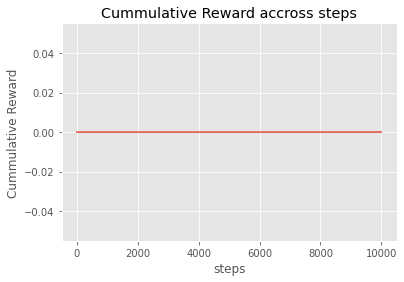

In [8]:
e.process_train_result()
e.test(MyForexEnv(df=EURUSD_HOUR, window_size=30, frame_bound=(80000, 90000)))